In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

from matplotlib.collections import LineCollection
import torchdata.datapipes as dp
from torch.utils.data import DataLoader

In [ ]:


def load_data(data_path):
    # list all csv files in the directory
    csv_files = os.listdir(data_path)
    csv_files = [f for f in csv_files if f.endswith(".csv")]

    worms=[]
    min_length = 9999999999
    for worm in csv_files:
        worm_data = np.genfromtxt(data_path+worm, delimiter=",", skip_header=1, dtype=np.float32)
        min_length = min(worm_data.shape[0], min_length)
        worms.append(worm_data)
    return worms, min_length


control_data,min_length1 = load_data("./data/Lifespan/control/")
drug_data,min_length2 = load_data("./data/Lifespan/companyDrug/")
min_length = min(min_length1,min_length2)
num_control = len(control_data)
num_drug = len(drug_data)




In [77]:
worms = control_data + drug_data
for i in range(len(worms)):
    worms[i] = worms[i][:min_length]

In [ ]:
data

In [ ]:
data = np.stack(worms, axis=0)


In [61]:



def colored_line(x, y, c, ax, **lc_kwargs):
    """
    Plot a line with a color specified along the line by a third value.

    It does this by creating a collection of line segments. Each line segment is
    made up of two straight lines each connecting the current (x, y) point to the
    midpoints of the lines connecting the current point with its two neighbors.
    This creates a smooth line with no gaps between the line segments.

    Parameters
    ----------
    x, y : array-like
        The horizontal and vertical coordinates of the data points.
    c : array-like
        The color values, which should be the same size as x and y.
    ax : Axes
        Axis object on which to plot the colored line.
    **lc_kwargs
        Any additional arguments to pass to matplotlib.collections.LineCollection
        constructor. This should not include the array keyword argument because
        that is set to the color argument. If provided, it will be overridden.

    Returns
    -------
    matplotlib.collections.LineCollection
        The generated line collection representing the colored line.
    """
    if "array" in lc_kwargs:
        warnings.warn('The provided "array" keyword argument will be overridden')

    # Default the capstyle to butt so that the line segments smoothly line up
    default_kwargs = {"capstyle": "butt"}
    default_kwargs.update(lc_kwargs)

    # Compute the midpoints of the line segments. Include the first and last points
    # twice so we don't need any special syntax later to handle them.
    x = np.asarray(x)
    y = np.asarray(y)
    x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
    y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))

    # Determine the start, middle, and end coordinate pair of each line segment.
    # Use the reshape to add an extra dimension so each pair of points is in its
    # own list. Then concatenate them to create:
    # [
    #   [(x1_start, y1_start), (x1_mid, y1_mid), (x1_end, y1_end)],
    #   [(x2_start, y2_start), (x2_mid, y2_mid), (x2_end, y2_end)],
    #   ...
    # ]
    coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
    coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
    coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
    segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)

    lc = LineCollection(segments, **default_kwargs)
    lc.set_array(c)  # set the colors of each segment

    return ax.add_collection(lc)


def plot_curve(X):
    """
    Plot a curve given by the points in X.

    Parameters
    ----------
    X : torch.Tensor
        The points on the curve. Should be a 2D tensor with shape (n_points, 3).
        each point represents a (t, x, y) value.
    """

    # -------------- Create and show plot --------------
    # Some arbitrary function that gives x, y, and color values
    t = X[:, 0].numpy()
    x = X[:, 1].numpy()
    y = X[:, 2].numpy()
    color = np.linspace(0, int(np.max(t)) + 1,t.size )  # color by t value

    # Create a figure and plot the line on it
    fig1, ax1 = plt.subplots()
    lines = colored_line(x, y, color, ax1,  cmap="plasma")
    fig1.colorbar(lines)  # add a color legend

    # Set the axis limits and tick positions
    ax1.set_xlim(np.nanmin(x), np.nanmax(x))
    ax1.set_ylim(np.nanmin(y), np.nanmax(y))
    # ax1.set_xticks((-1, 0, 1))
    # ax1.set_yticks((-1, 0, 1))
    ax1.set_title("worm movement")

    plt.show()

In [77]:
aa=torch.tensor([[0,0],[1,1],[2,1]],dtype=torch.float32)
torch.arccos(torch.dot(aa[-1]/torch.norm(aa[-1]),torch.tensor([1,0],dtype=torch.float32)))

# plot_curve(aa)

tensor(0.4636)

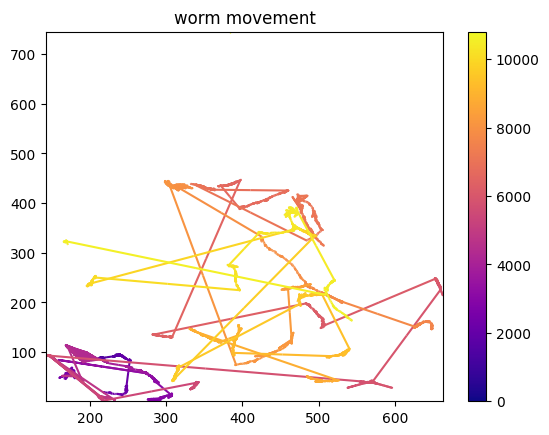

In [79]:
plot_curve(t_xy[1])

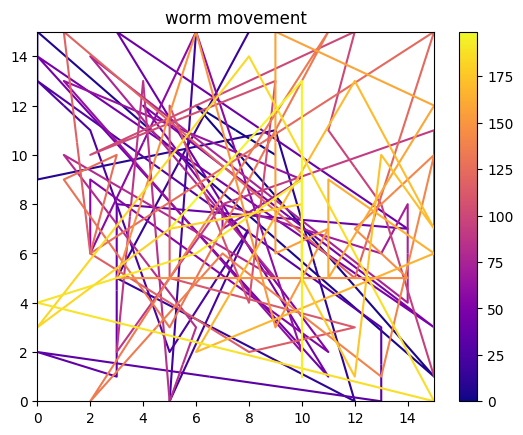

In [78]:
# dummy data
# x = torch.tensor([[[i*num*k for i in range(200)] for k in range(10)]for num in range(5)], dtype=torch.float32).reshape(5,10, 100, 2)
x = (torch.rand(5,10, 100, 2)*16).floor()
x[2][2]
def append_t(x):
    t=torch.linspace(0, (x.shape[0]-1)*2, x.shape[0] )
    return torch.cat((t.reshape(-1,1), x), dim=1)
# t=torch.linspace(0, (x[2][2].shape[0]-1)*2, x[2][2].shape[0] )
# x_with_t=torch.cat((t.reshape(-1,1), x[2][2]), dim=1)
plot_curve(append_t(x[1][2]))


In [152]:
x=xy

In [ ]:
x = xy
y = torch.tensor([0]*num_control + [1]*num_drug, dtype=torch.float32)

In [153]:
x.shape

torch.Size([22, 53995, 2])

In [ ]:
t_xy = torch.tensor(data[:, :, [0,2,3]])
xy = t_xy[:, :, 1:]

In [107]:
speed

tensor([[0.4529, 0.2991, 0.0206,  ..., 0.0367, 0.0753, 0.6915],
        [0.4010, 0.1575, 0.1163,  ...,    nan,    nan,    nan],
        [0.0846, 0.0747, 0.0000,  ..., 1.0725, 1.0767, 0.9199],
        ...,
        [0.6574, 0.1181, 0.0602,  ..., 0.5716, 1.9168, 2.2713],
        [0.8451, 0.4221, 0.1719,  ..., 0.9614, 0.9815, 0.6923],
        [0.3438, 0.1952, 0.0000,  ..., 0.0000, 0.0000, 0.5107]])

In [137]:
x=x[:,:1000,:]

In [154]:
last_frame = torch.roll(x, 1, 1) 
delta_xy = (x - last_frame)[:,1:]
total_distance = torch.norm(delta_xy, dim=2).nansum(dim=1)
speed = torch.norm(delta_xy, dim=2)
# avg_speed = torch.mean(avg_speed_single_period, dim=1)
# print(avg_speed_single_period)
# print(total_distance)

# def avg_first_k_periods(x, k, type='all'):
#     if type=='all':
#         avg_single_period = torch.mean(x, dim=2)
#         avg = torch.mean(avg_single_period[:,:k], dim=1,dtype=torch.float32)
#     else:
#         avg = torch.mean(x[:,:k], dim=1,dtype=torch.float32)
#     return avg

def var_x(x):
    return torch.var(x, dim=1)

def avg_x(x):
    return torch.nanmean(x, dim=1)
     
# def var_first_k_periods(x, k):
#     avg_single_period = torch.mean(x, dim=2)
#     avg = torch.var(avg_single_period[:,:k], dim=1)
#     return avg

# def avg_across_periods(x,start,end):
#     avg_single_period = torch.mean(x, dim=2)
#     var = torch.mean(avg_single_period[:,start:end], dim=1)
#     return var

# avg_speed_first_2_periods = avg_first_k_periods(speed, 2)

avg_speed = avg_x(speed)
# var_speed = var_x(speed)



In [80]:
grid_size =16
ax = torch.linspace(0, grid_size-1, grid_size)
grid = torch.cartesian_prod(ax, ax).reshape(1,1,1,grid_size**2,2)
num_pixel_spanned  = (grid == x.unsqueeze(3)).all(dim=4).sum(dim=2, dtype=torch.bool).sum(dim=2)

In [99]:
speed.shape

torch.Size([22, 53994])

In [155]:
acceleration = (speed - torch.roll(speed, 1, 1))[:,1:]

# avg_acc_first_2_periods = avg_first_k_periods(acceleration, 2)

avg_acc = avg_x(acceleration)




In [113]:
(speed ==0).sum(dim=1)

tensor([ 6092, 16538,  8913, 10061,  1753,  6908,  3348,  5898,   907,  2749,
         5664, 19575,  2378,  2895,  1686,  3839,  1991,  4432, 19978,  8826,
        10119, 13413])

In [156]:
threshold = 0
active_frames = speed > threshold
active_time = torch.sum(active_frames, dim=1)
# avg_active_time = torch.mean(active_time, dim=1,dtype=torch.float32)

active_time




tensor([47902, 33250, 44887, 42590, 52241, 47041, 50034, 47145, 51284, 50023,
        45448, 34288, 51616, 51099, 50278, 50155, 49879, 47603, 33950, 45168,
        43875, 40437])

In [157]:
sharp_turn_count = torch.sum(torch.sum(delta_xy*torch.roll(delta_xy, 1, 1),dim=2)[:,2:]<0,dim=1)

sharp_turn_count


tensor([18546, 10630, 18153, 16393, 20330, 18385, 18170, 19260, 19843, 17848,
        16102, 10020, 22559, 23351, 21511, 22055, 21176, 18333, 10822, 17614,
        15443, 12840])

In [158]:
angle_turned = torch.abs(torch.acos(torch.sum(delta_xy*torch.roll(delta_xy, 1, 1),dim=2)[:,2:]/(torch.norm(delta_xy, dim=2)[:,2:]*torch.norm(torch.roll(delta_xy, 1, 1), dim=2)[:,2:])).nan_to_num())
avg_angle_turned= torch.nanmean(angle_turned, dim=1)


In [ ]:
x_shifted = x-x[:,:,0,:].unsqueeze(2)
rotation_angle = -torch.arctan(x_shifted[:,:,-1,1]/x_shifted[:,:,-1,0]).unsqueeze(2)
# angles = torch.arctan(x_shifted[:,:,:,1]/x_shifted[:,:,:,0])
# rotation_angles = end_angle - angles
cos_rot = torch.cos(rotation_angle).unsqueeze(3)
sin_rot = torch.sin(rotation_angle).unsqueeze(3)
rotated_x = torch.sum(x_shifted.unsqueeze(3)*torch.cat((cos_rot, -sin_rot,sin_rot,cos_rot), dim=3).reshape(x_shifted.shape[0],x_shifted.shape[1],1,2,2),axis=4)
# rotated_x = torch.cat((x_shifted[:,:,:,0]*cos_rot - x_shifted[:,:,:,1]*sin_rot, x_shifted[:,:,:,0]*sin_rot + x_shifted[:,:,:,1]*cos_rot), dim=3)

final_x=torch.where(torch.isnan(rotated_x), x_shifted, rotated_x)
plot_curve(append_t(final_x[1][2]))
final_x[1,2,-1]

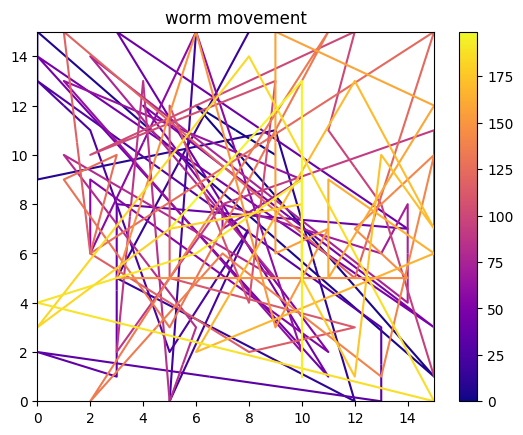

In [86]:
plot_curve(append_t(x[1][2]))

In [87]:
from frechetdist import frdist

def frechet_distance_with_previous_period(x):
    frechet_dist = torch.zeros(x.shape[0], x.shape[1]-1)
    for i in range(x.shape[0]):
        for period in range(x.shape[1]-1):
            reflection_mask =  torch.ones(x.shape,dtype=torch.float32)
            reflection_mask[:,:,:,1]=-1
            reflected = x*reflection_mask
            frechet_dist[i][period] = min(frdist(x[i][period], x[i][period+1]), frdist(x[i][period], reflected[i][period+1]))
    return frechet_dist

frechet_dist_with_previous_period = frechet_distance_with_previous_period(final_x)


In [96]:
k=2
features = torch.stack((avg_first_k_periods(speed,k), avg_first_k_periods(total_distance,k,type="periods"), avg_first_k_periods(num_pixel_spanned,k,type="periods"), avg_first_k_periods(acceleration,k), avg_first_k_periods(active_time,k,type="periods"), avg_first_k_periods(sharp_turn_count,k,type="periods"), avg_first_k_periods(avg_angle_turned,k,type="periods"), avg_first_k_periods(frechet_dist_with_previous_period,k-1,type="periods")), dim=0).T

In [104]:
avg_first_k_periods(speed,k)

tensor([8.3595, 8.7115, 8.4700, 8.4041, 8.4556])

In [172]:
features = torch.stack((avg_speed, total_distance, avg_acc, active_time, sharp_turn_count, avg_angle_turned), dim=1)
# add constant term
features = torch.cat((torch.ones((features.shape[0],1)), features), dim=1)
features.shape

torch.Size([22, 7])

In [173]:
def normalize(features):
    return (features - torch.mean(features, dim=0))/torch.std(features, dim=0)

In [160]:
tx = normalize(features)

In [129]:
y_train

tensor([0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0.])

In [174]:
# linear classifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

X_train, X_test, y_train, y_test = train_test_split(tx, y, test_size=0.33, random_state=42)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(accuracy_score(y_test, y_pred))

# confusion_matrix(y_test, y_pred)


0.625


In [175]:
# random forest
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

print(f1_score(y_test, y_pred))

confusion_matrix(y_test, y_pred)

clf.feature_importances_

# train accuracy
y_pred = clf.predict(X_train)
print(accuracy_score(y_train, y_pred))


0.75
0.75
0.9285714285714286


In [176]:
# SVM classifier
from sklearn import svm

clf = svm.SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

confusion_matrix(y_test, y_pred)

# train accuracy
y_pred = clf.predict(X_train)
print(accuracy_score(y_train, y_pred))






0.75
0.75
0.7857142857142857


In [180]:
# knn classifier
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred))


# train accuracy
y_pred = clf.predict(X_train)
print(accuracy_score(y_train, y_pred))


0.75
0.75
0.7857142857142857
